In [1]:
import os
import time
import sys

os.environ['MKL_NUM_THREADS'] = '2'
os.environ['OMP_NUM_THREADS'] = '2'
os.environ['GOTO_NUM_THREADS'] = '2'

import numpy as np
import pylab as plt
import matplotlib as mpl
from scipy import stats

import pymc3 as pm
import theano
import theano.tensor as tt
from scipy.signal import savgol_filter

sys.path.append('/media/bigdata/firing_space_plot/ephys_data/')
import visualize as vz

## Generate synthetic data

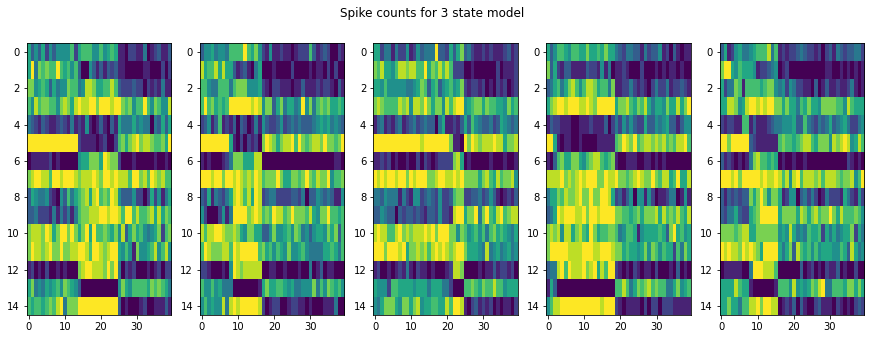

In [80]:
# Some poisson spiking
length = 400
bin_width = 10
states = 3
nrns = 15
tastes = 4
trials = 5
idx = np.arange(length)

#true_tau = np.cumsum(np.random.random((tastes,trials,states)),axis=-1)
true_tau = np.cumsum(np.random.uniform(2,30, size = (tastes,trials,states)),axis=-1)
true_tau /= np.max(true_tau,axis=-1)[...,np.newaxis]
true_tau *= length
true_tau = np.vectorize(np.int)(true_tau)

state_inds = np.concatenate([np.zeros((tastes,trials,1)),true_tau],axis=-1)
state_inds = np.vectorize(np.int)(state_inds)

true_lambda = np.random.random((tastes,nrns,states))

true_r = np.zeros((tastes,trials, nrns, length))

for taste in range(tastes):
    for trial_num in range(trials):
        for state_num in range(states):
            true_r[taste,trial_num,:,state_inds[taste,trial_num,state_num]:state_inds[taste,trial_num,state_num+1]] = \
                            true_lambda[taste,:,state_num][:,np.newaxis]
        
data_array = np.random.random(true_r.shape) < true_r   

# Spike array : tastes x trials x neurons x timebins
spike_array = np.sum(data_array.reshape((*data_array.shape[:3],-1,bin_width)),axis=-1)
spike_array_long = np.concatenate(spike_array, axis=0) 

## Visualize some trials
taste_ind = 0
trial_count = 5

imshow_kwargs = dict(interpolation = 'nearest', aspect = 'auto')
fig,ax = plt.subplots(1,trial_count, figsize = (15,5))
for plot_dat, this_ax in zip(spike_array[taste_ind][:trial_count], ax.flatten()):
    this_ax.imshow(plot_dat, **imshow_kwargs)
plt.suptitle(f'Spike counts for {states} state model');

In [81]:
################
# Generate shuffled data
# Spike array : tastes x trials x neurons x timebins
inds = list(np.ndindex((data_array.shape[0], *data_array.shape[2:])))
shuffle_data = np.zeros(data_array.shape)

for this_ind in inds:
    shuffle_data[this_ind[0],:,this_ind[1], this_ind[2]] = np.random.permutation(data_array[this_ind[0],:,this_ind[1], this_ind[2]])
shuffle_spikes = np.sum(shuffle_data.reshape((*shuffle_data.shape[:3],-1,bin_width)),axis=-1)
shuffle_spikes = np.vectorize(np.int)(shuffle_spikes)    

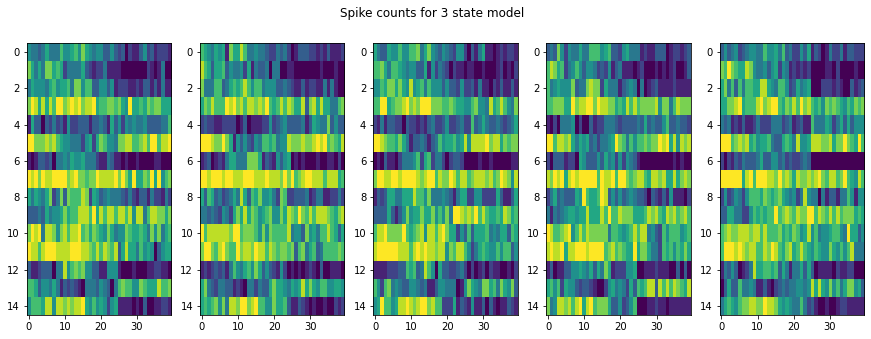

In [82]:
## Visualize some trials
taste_ind = 0
trial_count = 5

imshow_kwargs = dict(interpolation = 'nearest', aspect = 'auto')
fig,ax = plt.subplots(1,trial_count, figsize = (15,5))
for plot_dat, this_ax in zip(shuffle_spikes[taste_ind][:trial_count], ax.flatten()):
    this_ax.imshow(plot_dat, **imshow_kwargs)
plt.suptitle(f'Spike counts for {states} state model');

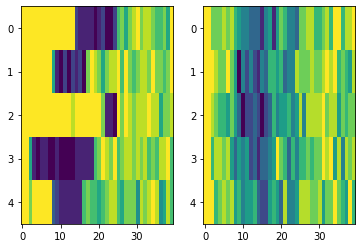

In [83]:
# Single neuron plots
fig,ax = plt.subplots(1,2)
taste_ind = 0
nrn_ind = 5
img_kwargs = dict(aspect='auto', interpolation='nearest')
ax[0].imshow(spike_array[taste_ind,:,nrn_ind], **img_kwargs)
ax[1].imshow(shuffle_spikes[taste_ind,:,nrn_ind], **img_kwargs)

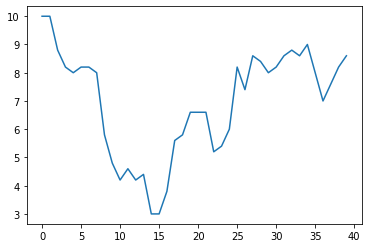

In [84]:
data_list = [spike_array[taste_ind,:,nrn_ind], shuffle_spikes[taste_ind,:,nrn_ind]]
mean_change = np.mean(data_list[0],axis=0)
plt.plot(mean_change)

In [85]:
data_list[0].shape[1]

40

(50, 5, 40)


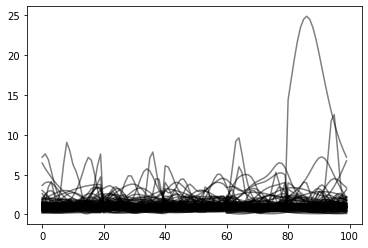

In [93]:
x = np.arange(data_list[0].shape[1])
with pm.Model() as model:
  
    ℓ = pm.Gamma("ℓ", alpha=5, beta=1)
    η = pm.Gamma("η", alpha=0.7, beta=2)#pm.HalfCauchy("η", beta=0.1)
    # Specify the covariance function.
    #http://evelinag.com/Ariadne/covarianceFunctions.html
    cov = η * pm.gp.cov.ExpQuad(1, ls=ℓ)
    gp = pm.gp.Latent(cov_func=cov)
    
    lambda_latent = pm.Deterministic('lambda_latent',
                    tt.stack([
                    gp.prior(f"f{i}", X=x[:, None]) \
        for i in range(trials)]))
    lambda_ = pm.Deterministic('lambda_', tt.exp(lambda_latent))
    prior_checks = pm.sample_prior_predictive(samples=50)
    
print(prior_checks['lambda_'].shape)
plt.plot(prior_checks['lambda_'].reshape((-1,100)).T, color = 'k', alpha = 0.5);

In [94]:
with pm.Model() as model:
    data = pm.Data('data', data_list[0])
    #hyper_step = pm.Exponential("hyper_step", 0.05)
    #step_size = pm.Exponential("step_size", hyper_step, shape = trials)
    
    ℓ = pm.Gamma("ℓ", alpha=1, beta=1, testval = 0.5)
    η = pm.HalfCauchy("η", beta=5, testval = 1.5)
    # Specify the covariance function.
    #http://evelinag.com/Ariadne/covarianceFunctions.html
    cov = (η ** 2) * pm.gp.cov.ExpQuad(1, ls=ℓ)
    gp = pm.gp.Latent(cov_func=cov)
    
    lambda_latent = tt.stack([
                    gp.prior(f"f{i}", X=x[:, None]) \
        for i in range(trials)])
    
    #lambda_latent = tt.stack([pm.GaussianRandomWalk(f"volatility{i}", sigma=step_size[i], 
    #                shape=length//bin_width) for i in range(trials)])
    lambda_ = pm.Deterministic('lambda_', np.exp(lambda_latent))
    rate = pm.Poisson("rate", lambda_, observed=data)

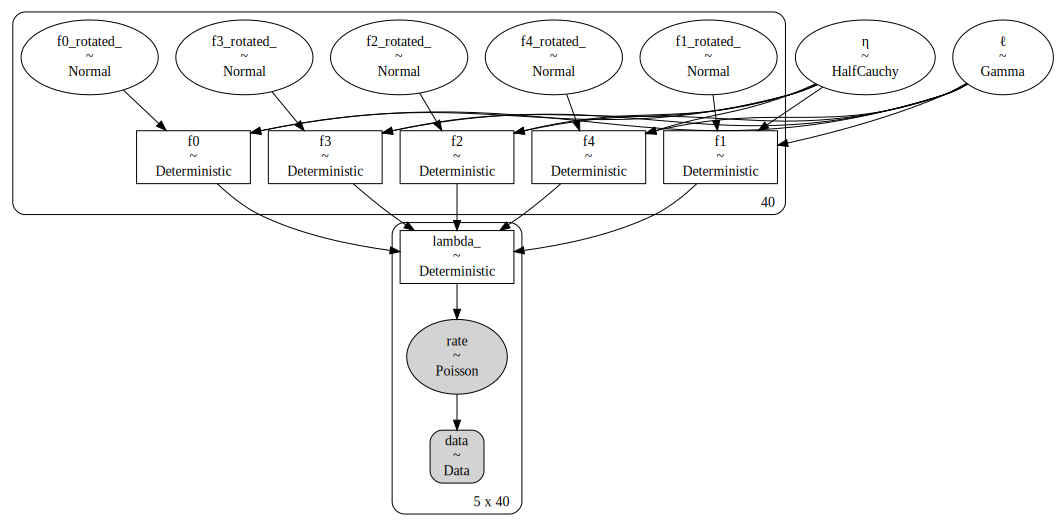

In [95]:
pm.model_to_graphviz(model)

In [96]:
trace_list = []
for this_data in data_list:
    with model:
        pm.set_data({'data': this_data})
        trace = pm.sample(1000, chains=1, cores=1)
        trace_list.append(trace[::10])
    
#         inference = pm.ADVI('full-rank')
#         approx = pm.fit(n=160000, method=inference)
#         trace = approx.sample(draws=2000)
#         trace_list.append(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [f4_rotated_, f3_rotated_, f2_rotated_, f1_rotated_, f0_rotated_, η, ℓ]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 217 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [f4_rotated_, f3_rotated_, f2_rotated_, f1_rotated_, f0_rotated_, η, ℓ]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 232 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [107]:
import arviz as az
df_comp_loo = az.compare({"sharp": trace_list[0], "smooth": trace_list[1]})
df_comp_loo

/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/arviz/stats/stats.py:147: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  "The default method used to estimate the weights for each model,"
/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/arviz/stats/stats.py:693: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likel

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
smooth,0,-424.914451,8.412246,0.000000,1.000000e+00,4.301639,0.000000,True,log
sharp,1,-724.811153,127.188724,299.896702,6.843948e-11,49.850603,50.221005,True,log


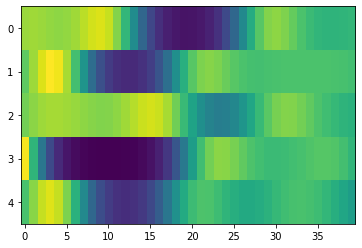

In [97]:
#plt.imshow(np.stack([trace_list[0][f'volatility{i}'].mean(axis=0) for i in range(trials)]), **img_kwargs)
plt.imshow(trace_list[0]['lambda_'].mean(axis=0), **img_kwargs)

In [98]:
# thinning = 10
# trace = trace[::thinning]

In [99]:
# with model:
#     pm.traceplot(trace, var_names = ['step_size'])

In [100]:
# with model:
#     pm.autocorrplot(trace, var_names = ['step_size']);

In [101]:
ppc_list = [pm.sample_posterior_predictive(x, samples = 2000, model = model, var_names = ['lambda_']) for x in trace_list]

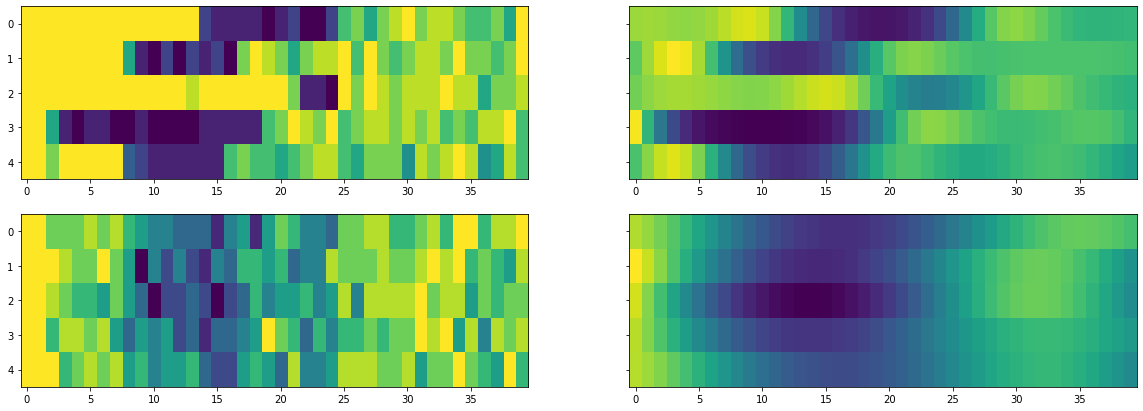

In [102]:
fig, ax = plt.subplots(2,2, figsize = (20,7), sharey = True)
ax[0,0].imshow(data_list[0], **img_kwargs)
ax[0,1].imshow(np.mean(ppc_list[0]['lambda_'],axis=0), **img_kwargs);

#==========================================================
ax[1,0].imshow(data_list[1], **img_kwargs)
ax[1,1].imshow(np.mean(ppc_list[1]['lambda_'],axis=0), **img_kwargs);

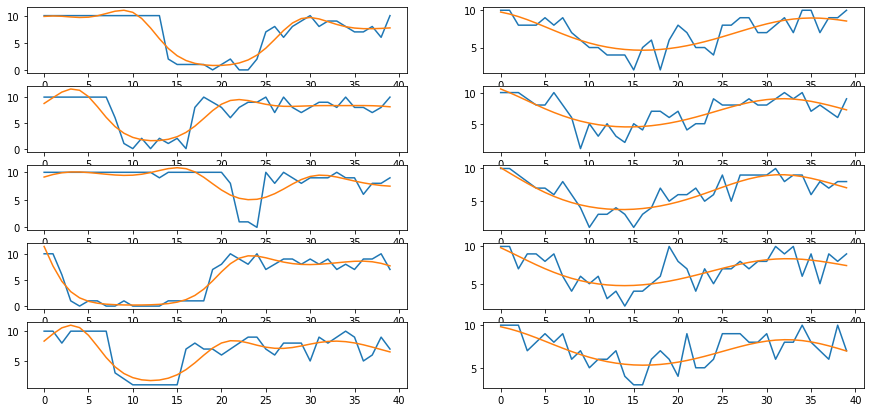

In [103]:
fig,ax = plt.subplots(trials,2, figsize = (15,7))
for num, this_ax in enumerate(ax):
    this_ax[0].plot(data_list[0][num])
    this_ax[0].plot(np.mean(ppc_list[0]['lambda_'],axis=0)[num])
    this_ax[1].plot(data_list[1][num])
    this_ax[1].plot(np.mean(ppc_list[1]['lambda_'],axis=0)[num])

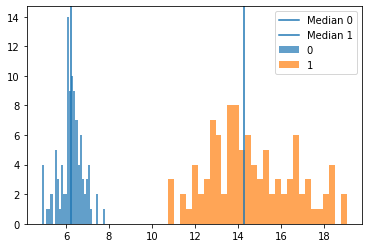

In [104]:
for num, this_trace in enumerate(trace_list):
    plt.hist(this_trace['ℓ'], alpha = 0.7, label = str(num), bins = 30)
    plt.axvline(np.median(this_trace['ℓ']), label = f'Median {num}')
plt.legend()

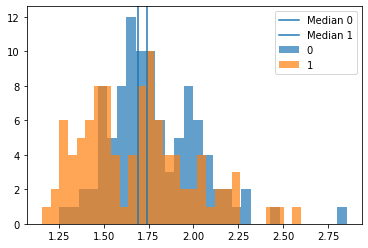

In [105]:
for num, this_trace in enumerate(trace_list):
    plt.hist(this_trace['η'], alpha = 0.7, label = str(num), bins = 30)
    plt.axvline(np.median(this_trace['η']), label = f'Median {num}')
plt.legend()